Author: Felix Di Nezza IT DBA

DATA SOURCES <br>

Reddit Climate Change <br>
Author: Lexyr <br>
Source: https://www.kaggle.com/datasets/pavellexyr/the-reddit-climate-change-dataset <br>
Data collected using [SocialGrep Exports](https://socialgrep.com/exports) <br>

Twitter data <br>
Author: DEEPSENSE <br>
source: https://drive.google.com/drive/folders/1I697IvjVO33NpKDOm85CuudItyFY5k4o <br>

LICENCE <br>
Attribution 4.0 International (CC BY 4.0) <br>
https://creativecommons.org/licenses/by/4.0/ <br>

CHANGES AND USAGE <br>
Dataset used for sentiment analysis

REFERENCES

Sentiment analysis on twitter <br>
https://medium.com/mlearning-ai/elon-musks-twitter-sentiment-analysis-with-transformers-hugging-face-roberta-49b9e61b1433 <br>

Tutorial nltk & roberta <br>
https://www.youtube.com/watch?v=QpzMWQvxXWk <br>

Python regex functions <br>
https://pynative.com/python-regex-compile/ <br>

Word cloud tutorial <br>
https://medium.com/mcd-unison/create-word-cloud-scraping-data-from-reddit-api-using-praw-and-spacy-b5c9c61c2d10 <br>


In [42]:
## additional installs
#!pip install emoji
#!pip install emot

In [43]:
import collections
import csv
import numpy as np
import seaborn as sns
import pandas as pd
import re
import emoji
import pathlib
import tqdm
import string

# plot
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# nltk 
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('stopwords')
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer

# progress bar
from tqdm.notebook import tqdm

#emoji filter
from emot.emo_unicode import UNICODE_EMOJI, EMOTICONS_EMO

[nltk_data] Downloading package punkt to /home/tx/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/tx/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /home/tx/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /home/tx/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /home/tx/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /home/tx/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [44]:
# import csv
with open ( './the-reddit-climate-change-dataset-comments.csv',
            'r',
            encoding="utf8",
            newline='\n'
          ) as source_csv: 
            reader = csv.reader(source_csv)
            df = pd.read_csv(source_csv)

In [4]:
# print size of the dataframe
print(df.shape)

# return first row 
df['body'].values[0]


(4600698, 10)


'Yeah but what the above commenter is saying is their base doesn’t want any of that. They detest all of those things, even the small gradual changes. Investing in nuclear energy is a tacit acknowledgement of man made climate change. Any acknowledgement or concession and they will be primaried out in a minute'

In [5]:
#check dataframe information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600698 entries, 0 to 4600697
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   type            object 
 1   id              object 
 2   subreddit.id    object 
 3   subreddit.name  object 
 4   subreddit.nsfw  bool   
 5   created_utc     int64  
 6   permalink       object 
 7   body            object 
 8   sentiment       float64
 9   score           int64  
dtypes: bool(1), float64(1), int64(2), object(6)
memory usage: 320.3+ MB


In [6]:
# get first 5 rows to check content structure
df.head()

,type,id,subreddit.id,subreddit.name,subreddit.nsfw,created_utc,permalink,body,sentiment,score
0,comment,imlddn9,2qh3l,news,False,1661990368,https://old.reddit.com/r/news/comments/x2cszk/...,Yeah but what the above commenter is saying is...,0.5719,2
1,comment,imldbeh,2qn7b,ohio,False,1661990340,https://old.reddit.com/r/Ohio/comments/x2awnp/...,Any comparison of efficiency between solar and...,-0.9877,2
2,comment,imldado,2qhma,newzealand,False,1661990327,https://old.reddit.com/r/newzealand/comments/x...,I'm honestly waiting for climate change and th...,-0.1143,1
3,comment,imld6cb,2qi09,sacramento,False,1661990278,https://old.reddit.com/r/Sacramento/comments/x...,Not just Sacramento. It's actually happening a...,0.0000,4
4,comment,imld0kj,2qh1i,askreddit,False,1661990206,https://old.reddit.com/r/AskReddit/comments/x2...,I think climate change tends to get some peopl...,0.6634,1


In [7]:
# multiparameter search to check for number of results returned
# dataframe[column to visualize][search based on column]

df[['body', 'subreddit.name']][
           (
           df['body'].str.contains('micro-plastic', na = False) |
           df['body'].str.contains('microplastic', na = False) |
           df['body'].str.contains('Microplastic', na = False) |
           df['body'].str.contains('Micro-plastic', na = False)
           ) &
           (
           df['body'].str.contains('ocean', na = False) |
           df['body'].str.contains('lake', na = False) |
           df['body'].str.contains('water', na = False) |
           df['body'].str.contains('Ocean', na = False) |
           df['body'].str.contains('Lake', na = False) |
           df['body'].str.contains('Water', na = False)
           )
          ].count()

body              1289
subreddit.name    1289
dtype: int64

In [8]:
#test retrived data
print(df[['subreddit.name','body']].values[11930])

['collapse'
 'I agree with everything you are saying.\n\n\nI mean it is really bad and we have no experience with what a century of micro-plastic exposure will do to humanity and the environment, I am glad the EPA is taking it seriously and lowering it\'s guidance to "no plastic at all in water" which lead to the all rainwater is all contaminated headline.\n\n\nWhat we know about micro-plastics is that they clog things up and if they get in your body they get stuck all over the place forever.  Including the brain.  Just like Lead.  The horrifying thing is that micro-plastics are literally in everything we drink, eat, and breathe.  When lead or arsenic gets in local water we notice within a couple years due to the acute cancer/dementia/etc prevalence, so far I haven\'t seen a "microplastics causing dementia in X city water supply" type of story yet it mostly seems to be things like [Plastic physically blocking things](https://resource.co/article/plastic-pollution-causing-health-crisis-p

In [9]:
# extract subset with key words
# later test improvement with regex
sub_kw = df[['id','subreddit.name','body']][
           (
           df['body'].str.contains('micro-plastic', na = False) |
           df['body'].str.contains('microplastic', na = False) |
           df['body'].str.contains('Microplastic', na = False) |
           df['body'].str.contains('Micro-plastic', na = False)
           ) &
           (
           df['body'].str.contains('ocean', na = False) |
           df['body'].str.contains('lake', na = False) |
           df['body'].str.contains('water', na = False) |
           df['body'].str.contains('Ocean', na = False) |
           df['body'].str.contains('Lake', na = False) |
           df['body'].str.contains('Water', na = False)
           )
          ]


In [10]:
# check content sub-search
sub_kw[['subreddit.name', 'body']].values[129]

array(['damnthatsinteresting',
       "Edit: formatting. Bolded and double tabbed the relevant info. You're both right for different reasons, but I think the comment about china, India, Indonesia, vis-a-vis ocean dumping, goes to the other guy. \n\nhttps://www.ciwem.org/news/10-countries-biggest-contributors-marine-plastic-pollution\n\n&gt;Marine plastics are choking our oceans, with figures from cited by the International Union for Conservation of Nature (IUCN) revealing that a staggering 8 million tons of plastic end up in our oceans every year, having a devastating effect on aquatic life, human health as well as climate change impacts – read more about this in our Addicted to Plastic: Microplastic Pollution and Prevention report.\n\n&gt;And as #PlasticFreeJuly enters its second week figures from packaging retailer RAJA UK have revealed the 10 countries responsible for throwing the highest amount of plastic into the ocean.\n\n&gt;&gt;**Calculating the amount of plastics that end up i

In [11]:

# Data cleansing functions
# must optimize

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

# remove links
def remove_links(text):
    '''Takes a string and removes web links from it'''
    text = re.sub(r'http\S+', '', text) # remove http links
    text = re.sub(r'bit.ly/\S+', '', text) # remove bitly links
    text = text.strip('[link]') # remove [links]
    return text

#remove HTML
def clean_html(text):
    html = re.sub('&lt;/?[a-z]+&gt;', '', text)
    html = re.sub('&ft;/?[a-z]+&gt;', '', text)
    html = re.compile('<.*?>')#regex
    return html.sub(r'',text)


#remove special special characters
def rem_spec_c(text):
    text = re.sub('([_]+)', "", text)
    return text

# remove punctuation
def clean_symb(text):
    text = re.sub(r'[^\w\s]',' ',text) # remove all except letters and spaces
    return text

# grab hashtags
def hashtags(text):
    hash = re.findall(r"#(\w+)", text)
    return hash

# remove hashtags
def rem_hashtags(text):
    text = re.sub(r"#(\w+)", '', text)
    return text

# remove reddit usernames
def remove_users(text):
    '''Takes a string and removes u/user_name'''
    text = re.sub('(u/[A-Za-z]+[A-Za-z0-9-_]+)', '', text) 
    return text

# remove twitter user
def rem_usr_twt(text):
    '''Takes a string and removes u/user_name'''
    text = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', text) 
    return text

# translate emoji
def emoji_conv(text):
    for emot in UNICODE_EMOJI:
        if text == None:
            text = text
        else:
            text = text.replace(emot, "_".join(UNICODE_EMOJI[emot].replace(",", "").replace(":", "").split()))
    return text

# remove non ascii character
def non_ascii(s):
    return "".join(i for i in s if ord(i)<128)

# turn all in low char
def lower(text):
    return text.lower()


# remove emoji
def emoji_remove(text):
    for emot in UNICODE_EMOJI:
        if text == None:
            text = text
        else:
            text = text.replace(emot, ' ')
    return text



In [12]:
# test 1
# # run polarity score on the entire dataset
# res = {} # this is a dicitonary
# for i, row in tqdm(df.iterrows(), total=len(df)):
#     text = row['body']
#     myid = row['id']
#     res[myid] = sia.polarity_scores(text)
#     break
    

In [13]:
# check first 5 rows from subset
sub_kw.head()

,id,subreddit.name,body
1596,imiiely,philadelphia,Yeah but it solidified it after the pandemic. ...
2092,imhhgxq,antitheistcheesecake,The rambling does not make much sense.\n\nFirs...
3473,imeohun,science,You can reduce your exposure by avoiding produ...
8805,im6m7p6,196,One guy having an idea doesn't mean that every...
10140,im4lujd,teenagers,Climate change gets set back to 0 (don't fuck ...


In [14]:
# prepare sentiment analyzer
sia = SentimentIntensityAnalyzer()

In [15]:
# cleansing for rumor
for i, row in tqdm (sub_kw.iterrows(), total=len(sub_kw)):
    text = row['body']
    # cleansing
    text = lower(text)
    text = remove_links(text)
    text = clean_html(text)
    text = emoji_remove(text)
    row['body'] = text
    myid = row['id']

  0%|          | 0/1289 [00:00<?, ?it/s]

In [16]:
# return first row to test
# print(sub_kw.values[1])

In [17]:
# run polarity score on the subset with keywords
res = {} # this is a dictionary
for i, row in tqdm (sub_kw.iterrows(), total=len(sub_kw)):
    text = row['body']
    myid = row['id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/1289 [00:00<?, ?it/s]

In [18]:
# store result diciotnary in a pandas dataframe the T will flip it
vaders = pd.DataFrame(res).T
# reset and rename index
vaders = vaders.reset_index().rename(columns={'index': 'id'})
vaders.head()



,id,neg,neu,pos,compound
0,imiiely,0.137,0.804,0.059,-0.8338
1,imhhgxq,0.063,0.845,0.091,0.9329
2,imeohun,0.075,0.844,0.081,0.3612
3,im6m7p6,0.000,1.000,0.000,0.0000
4,im4lujd,0.061,0.863,0.076,0.4841


In [19]:
# merge the new calcualted index to the subset previously filtered with a left merge
vaders = vaders.merge(sub_kw, how='left') 
#vaders.head

In [20]:
# return first row of the header column to test
print(vaders.values[1])

['imhhgxq' 0.063 0.845 0.091 0.9329 'antitheistcheesecake'
 'the rambling does not make much sense.\n\nfirst science is not the same as technology. they are strongly related, but not the same.\n\ntechnology is basically "tools" you use and they are yes based on science, but then go through development to become things that (in general) anyone can use and (hopefully) work reliably,\n\nyou do not need to know the science behind your car or your phone. what you care is that they perform their task successfully and consistently.\n\nwhat people -often- do not trust is often new technology and untested technology. for example the new vaccines.\n\nnow i am a scientist myself and in the beginning i had my reservations getting the pfizer or moderna vaccines. there were reports from *reliable government sources (not us)* (so also "science^(tm)") and not some weird site or facebook, about side effects of these new types of vaccines and i did not feel like to be a gunea pig.\n\nthis is not because

In [21]:
vaders.head(3)

,id,neg,neu,pos,compound,subreddit.name,body
0,imiiely,0.137,0.804,0.059,-0.8338,philadelphia,yeah but it solidified it after the pandemic. ...
1,imhhgxq,0.063,0.845,0.091,0.9329,antitheistcheesecake,the rambling does not make much sense.\n\nfirs...
2,imeohun,0.075,0.844,0.081,0.3612,science,you can reduce your exposure by avoiding produ...


In [22]:
round(vaders['compound'].mean(),2)

-0.26

In [23]:
# add positive negative neutral association to allow group by
conv = {}
for i, row in tqdm (vaders.iterrows(), total=len(vaders)):
    value = row['compound']
    if value < 0 :
        exp = 'negative'
    if value > 0 :
        exp = 'positive'
    if value == 0 :
        exp = 'neutral'
    myid = row['id']
    conv[i] = myid, exp

  0%|          | 0/1289 [00:00<?, ?it/s]

In [24]:
# debug output
# conv

In [25]:
# turn it to a dataframe
results = pd.DataFrame(conv)

# verticalized frame
results = pd.DataFrame(conv).T

# name columns
results.columns=['id', 'type']




In [26]:
# test rotate output with renamed columns
results.head()

,id,type
0,imiiely,negative
1,imhhgxq,positive
2,imeohun,positive
3,im6m7p6,neutral
4,im4lujd,positive


In [27]:
#attach the dataframe to the vaders results

results = results.merge(vaders, how='left')

In [28]:
# check new dataframe
results.head()

,id,type,neg,neu,pos,compound,subreddit.name,body
0,imiiely,negative,0.137,0.804,0.059,-0.8338,philadelphia,yeah but it solidified it after the pandemic. ...
1,imhhgxq,positive,0.063,0.845,0.091,0.9329,antitheistcheesecake,the rambling does not make much sense.\n\nfirs...
2,imeohun,positive,0.075,0.844,0.081,0.3612,science,you can reduce your exposure by avoiding produ...
3,im6m7p6,neutral,0.000,1.000,0.000,0.0000,196,one guy having an idea doesn't mean that every...
4,im4lujd,positive,0.061,0.863,0.076,0.4841,teenagers,climate change gets set back to 0 (don't fuck ...


<Axes: title={'center': 'Sentiment #Microplastic'}>

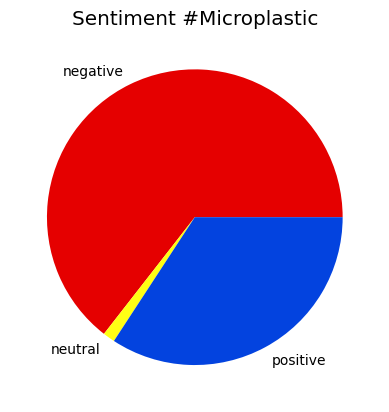

In [29]:
from matplotlib.colors import ListedColormap
# graph results 
cmap = ListedColormap(['#e50000', '#ffff14','#0343df']) # pie
#cmap = ListedColormap(['#0343df']) #bar
results['type'].value_counts().sort_index().plot(
                                            kind='pie',
                                            title='Sentiment #Microplastic',
                                            ylabel ='',
                                            colormap= cmap
                                            )

REDDIT WORD CLOUD

In [30]:
# !pip install wordcloud
# !pip install spacy
# !pip install PIL
!python -m spacy download en_core_web_sm

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import spacy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 11.9 MB/s eta 0:00:00m eta 0:00:010:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [31]:
#replace keyword with space
def rem_kw (text, kw):
    text = text.replace(kw, ' ')
    return text

test = ' &gthello&gt '
print(rem_kw(test, '&gt'))

  hello  


In [32]:
# clean and parse
nlp = spacy.load("en_core_web_sm")
nlp.max_length = 2409706 # 1gb ram every 1000000
words = '\n'.join(sub_kw.body)
words = lower(words)
words = rem_kw(words, '&gt')
words = remove_links(words)
words = clean_html(words)
words = remove_users(words)
words = emoji_remove(words)
words = clean_symb(words)
words = rem_spec_c(words)
text = nlp(words)

In [33]:
cloud = ""
for word in text:    
    if word.pos_ in ['ADJ','NOUN','PROPN']:
        cloud = " ".join((cloud, word.text.lower()))

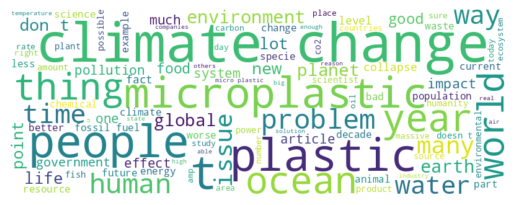

In [34]:
wordcloud = WordCloud(stopwords=STOPWORDS,
                      max_words=100,
                      background_color='white',
                      width=800,
                      height=300).generate(cloud)

plt.imshow(wordcloud,
           interpolation='bilinear')
plt.axis("off")
plt.show()

In [35]:
#print (cloud)

TWITTER WORD CLOUD



In [36]:
# open the csv and turn it into a dataframe
with open ('./plastic_pollution.csv',
'r',
encoding="utf8",
newline='\n') as source_csv:
    reader = csv.reader(source_csv)

    tdf = pd.read_csv(source_csv)

In [37]:
nlp = spacy.load("en_core_web_sm")
words = '\n'.join(tdf.description)
words = lower(words)
words = remove_links(words)
words = clean_html(words)
words = rem_kw(words, '&gt')
words = rem_hashtags(words)
words = rem_usr_twt(words)
words = emoji_remove(words)
words = clean_symb(words)
words = rem_spec_c(words)
text = nlp(words)

In [38]:
cloud2 = ""
for word in text:    
    if word.pos_ in ['ADJ','NOUN','PROPN']:
        cloud2 = " ".join((cloud2, word.text.lower()))

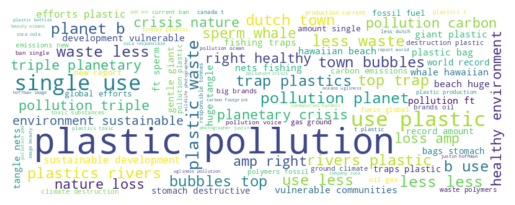

In [39]:
wordcloud = WordCloud(stopwords=STOPWORDS,
                          max_words=100,
                          background_color='white',
                          width=800, height=300).generate(cloud2)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [41]:
# debug 
# print (cloud2)